In [6]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_rows = 1000

# 50 unique categories
categories = [f"category_{i}" for i in range(1, 51)]

df = pd.DataFrame({
    "user_type": np.random.choice(categories, size=n_rows),   # object feature (50 attributes)
    "age": np.random.randint(18, 65, size=n_rows),
    "salary": np.random.randint(30000, 150000, size=n_rows),
    "experience_years": np.random.randint(0, 40, size=n_rows),
    "score": np.round(np.random.uniform(0, 100, size=n_rows), 2),
    "target": np.random.choice([0, 1], size=n_rows, p=[0.7, 0.3])
})

# Inject some missing values (for realism)
for col in ["age", "salary", "score"]:
    df.loc[df.sample(frac=0.08).index, col] = np.nan

df.head()


,user_type,age,salary,experience_years,score,target
0,category_39,50.0,121194.0,15,4.17,0
1,category_29,39.0,144306.0,7,39.76,0
2,category_15,NaN,90315.0,0,76.23,0
3,category_43,23.0,109561.0,4,NaN,0
4,category_8,23.0,38946.0,2,NaN,0


In [106]:
df.to_csv('dataset.csv')

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import time

In [44]:
# dataset = pd.read_csv('shopping_behavior_updated.csv')

In [45]:
# df =  pd.DataFrame(dataset)
# df.head()

In [3]:
columns = df.columns

In [4]:
columns

Index(['user_type', 'age', 'salary', 'experience_years', 'score', 'target'], dtype='object')

In [5]:
for col in columns:
    dtype = df[col].dtype
    print(dtype)

object
float64
float64
int32
float64
int64


### Filtering the Columns

In [7]:
def filter_function(df):
    # Select numeric (non-object) columns and return an explicit copy
    df2 = df.select_dtypes(exclude=['object']).copy()
    return df2


In [10]:
df2 = filter_function(df)
df2

,age,salary,experience_years,score,target
0,50.0,121194.0,15,4.17,0
1,39.0,144306.0,7,39.76,0
2,NaN,90315.0,0,76.23,0
3,23.0,109561.0,4,NaN,0
4,23.0,38946.0,2,NaN,0
...,...,...,...,...,...
995,36.0,39496.0,11,74.94,0
996,39.0,86447.0,23,43.11,0
997,54.0,131604.0,28,8.75,0
998,49.0,59806.0,24,28.28,0


<Axes: xlabel='target', ylabel='Count'>

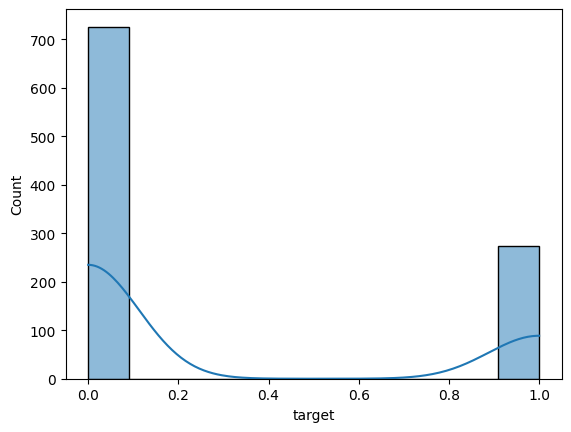

In [85]:
sns.histplot(df2['target'] , kde=True)


In [84]:
df2['target'].value_counts()

target
0    726
1    274
Name: count, dtype: int64

### Handling outliers

In [48]:
df.head(6)

,user_type,age,salary,experience_years,score,target
0,category_39,50.0,121194.0,15,4.17,0
1,category_29,39.0,144306.0,7,39.76,0
2,category_15,NaN,90315.0,0,76.23,0
3,category_43,23.0,109561.0,4,NaN,0
4,category_8,23.0,38946.0,2,NaN,0
5,category_21,21.0,124242.0,0,21.98,0


In [41]:
df2.isnull().sum()

age                 80
salary              80
experience_years     0
score               80
target               0
dtype: int64

### Handling Null Values

In [8]:
df.shape

(1000, 6)

In [9]:
df2.shape

(1000, 5)

In [10]:
df2.isnull().sum()

age                 80
salary              80
experience_years     0
score               80
target               0
dtype: int64

In [3]:
import pandas as pd
import numpy as np

In [16]:
def handling_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Return a new DataFrame after handling missing values per-column using simple rules:"""
    df_out = df.copy()
    for col in list(df_out.columns):
        missing_count = df_out[col].isnull().sum()
        total_count = len(df_out) if len(df_out) > 0 else 1
        missing_percentage = (missing_count / total_count)
        # If more than 30% missing, drop the column
        if missing_percentage > np.float64(0.3):
            print("{}: {:.2%} missing — dropping column".format(col, missing_percentage))
            print("The feature is unreliable due to excessive missing values.")
            continue
        # If no missing values, skip
        if missing_percentage == 0:
            print(f"{col}: no missing values")
            continue

        # # For imputation, treat numeric columns specially. For non-numeric, use mode.
        # if not is_numeric_dtype(df_out[col].dtype):
        #     mode_vals = df_out[col].mode()
        #     if len(mode_vals) > 0:
        #         fill_val = mode_vals.iloc[0]
        #         print(f"{col}: {missing_percentage:.2%} missing (non-numeric) — mode imputation")
        #         df_out[col] = df_out[col].fillna(fill_val)
        #     else:
        #         print(f"{col}: {missing_percentage:.2%} missing (non-numeric) — no mode available, leaving NA")
        #     continue

        # Numeric column: compute diagnostics to choose mean vs median
        col_series = df_out[col].dropna()
        mean_value = col_series.mean() if len(col_series) > 0 else 0.0
        median_value = col_series.median() if len(col_series) > 0 else 0.0

        # Mean-median relative distance
        denom = abs(median_value) if abs(median_value) > 0 else (abs(mean_value) if abs(mean_value) > 0 else 1.0)
        mean_median_distance = abs(mean_value - median_value) / denom

        # Skewness (absolute)
        skewness = abs(col_series.skew()) if len(col_series) > 2 else 0.0

        # Outlier percentage using IQR rule
        q1 = col_series.quantile(0.25)
        q3 = col_series.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0:
            outlier_percentage = 0.0
        else:
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outlier_count = ((col_series < lower) | (col_series > upper)).sum()
            outlier_percentage = outlier_count / len(col_series)

        # Threshold: 5% (0.05). If all three diagnostics are below threshold -> mean, else median
        threshold = 0.05
        use_mean = (mean_median_distance < threshold) and (skewness < threshold) and (outlier_percentage < threshold)

        if use_mean:
            print(f"{col}: {missing_percentage:.2%} missing — mean imputation (mean-median {mean_median_distance:.2%}, skew {skewness:.3f}, outliers {outlier_percentage:.2%})")
            df_out[col] = df_out[col].fillna(mean_value).round(2)
        else:
            print(f"{col}: {missing_percentage:.2%} missing — median imputation (mean-median {mean_median_distance:.2%}, skew {skewness:.3f}, outliers {outlier_percentage:.2%})")
            df_out[col] = df_out[col].fillna(median_value).round(2)
        print()
    return df_out

In [17]:
formatted_df = handling_missing_values(df2)
formatted_df.head()

age: 8.00% missing — mean imputation (mean-median 1.63%, skew 0.018, outliers 0.00%)

salary: 8.00% missing — mean imputation (mean-median 0.52%, skew 0.003, outliers 0.00%)

experience_years: no missing values
score: 8.00% missing — median imputation (mean-median 3.34%, skew 0.131, outliers 0.00%)

target: no missing values


,age,salary,experience_years,score,target
0,50.00,121194.0,15,4.17,0
1,39.00,144306.0,7,39.76,0
2,41.31,90315.0,0,76.23,0
3,23.00,109561.0,4,53.98,0
4,23.00,38946.0,2,53.98,0


In [18]:
df2.head()

,age,salary,experience_years,score,target
0,50.0,121194.0,15,4.17,0
1,39.0,144306.0,7,39.76,0
2,NaN,90315.0,0,76.23,0
3,23.0,109561.0,4,NaN,0
4,23.0,38946.0,2,NaN,0


In [13]:
import seaborn as sns

<Axes: xlabel='score', ylabel='Count'>

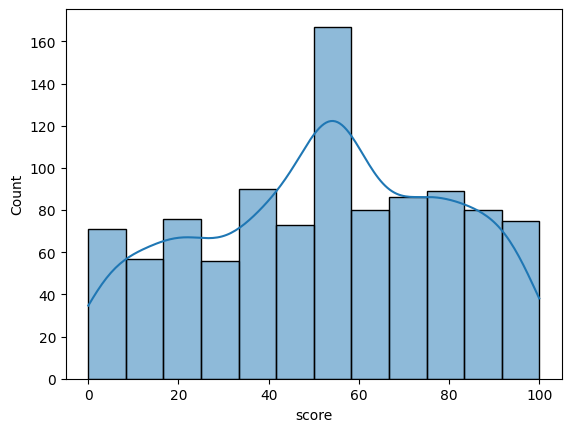

In [14]:
sns.histplot(formatted_df['score'] , kde=True)

<Axes: xlabel='target', ylabel='Count'>

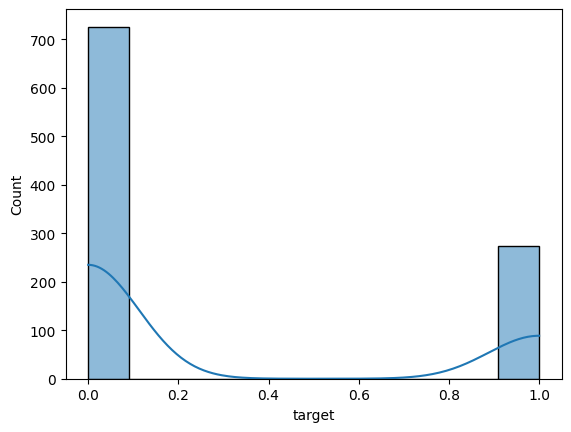

In [15]:
sns.histplot(formatted_df['target'] , kde=True)

In [ ]:
def outliers_cap(df, cap_percentiles=(0.01, 0.99)):
    """Cap numeric columns at the provided lower/upper percentiles (winsorization-like).
    Returns a new DataFrame with capped numeric values."""
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns
    low_p, high_p = cap_percentiles
    for col in numeric_cols:
        s = df_out[col].dropna()
        if s.empty:
            continue
        lower_cap = s.quantile(low_p)
        upper_cap = s.quantile(high_p)
        df_out[col] = df_out[col].clip(lower=lower_cap, upper=upper_cap)
    return df_out

def outliers_remove(df, iqr_multiplier=1.5):
    """Remove rows that are IQR-outliers in any numeric column."""
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) == 0:
        return df_out
    mask = pd.Series(True, index=df_out.index)
    for col in numeric_cols:
        s = df_out[col].dropna()
        if s.empty:
            continue
        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        mask &= ((df_out[col].isnull()) | ((df_out[col] >= lower) & (df_out[col] <= upper)))
    return df_out[mask].copy()

def outliers_impute(df, strategy='median', iqr_multiplier=1.5):
    """Impute outlier values detected by IQR with a robust statistic (median by default).
    For each numeric column, values outside [Q1 - m*IQR, Q3 + m*IQR] are replaced with the chosen statistic computed on non-outliers."""
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        s = df_out[col]
        non_null = s.dropna()
        if non_null.empty:
            continue
        Q1 = non_null.quantile(0.25)
        Q3 = non_null.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        non_outliers = non_null[(non_null >= lower) & (non_null <= upper)]
        if non_outliers.empty:
            # fallback to column median/mean if everything is extreme
            fill_val = non_null.median() if strategy == 'median' else non_null.mean()
        else:
            fill_val = non_outliers.median() if strategy == 'median' else non_outliers.mean()
        mask_outlier = (s < lower) | (s > upper)
        df_out.loc[mask_outlier, col] = fill_val
    return df_out

def outliers_robust_scale(df, with_centering=True, with_scaling=True):
    """Apply RobustScaler to numeric columns and return a new DataFrame.
    Uses median and IQR for scaling so outliers have reduced influence."""
    from sklearn.preprocessing import RobustScaler
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) == 0:
        return df_out
    scaler = RobustScaler(with_centering=with_centering, with_scaling=with_scaling)
    scaled = scaler.fit_transform(df_out[numeric_cols].astype(float))
    df_out[numeric_cols] = pd.DataFrame(scaled, index=df_out.index, columns=numeric_cols)
    return df_out

# Examples:
# df_clean = handling_missing_values(df2)
# df_capped = outliers_cap(df_clean)
# df_removed = outliers_remove(df_clean)
# df_imputed = outliers_impute(df_clean, strategy='median')
# df_scaled = outliers_robust_scale(df_clean)

In [105]:
formatted_df = handle_outliers_after_imputation(formatted_df)
formatted_df.head()

,age,salary,experience_years,score,target
0,50.0,121194.0,15,4.170,0
1,39.0,144306.0,7,39.760,0
2,42.0,90315.0,0,76.230,0
3,23.0,109561.0,4,53.975,0
4,23.0,38946.0,2,53.975,0


In [3]:
from pathlib import Path

from docling.document_converter import DocumentConverter

from docling_core.transforms.serializer.markdown import MarkdownDocSerializer
import os

# Configuration
csv_path = os.path.join("data", "dataset.csv")
# vector_db_path = os.path.join(base_dir, "vector_db")

In [4]:
csv_path

'data\\dataset.csv'

In [1]:

FILE_PATH = 'D:\\ML-Projects\\Gen AI Applications\\AI Data Analyst\\data\\dataset.csv'
# Convert CSV to Docling document
from langchain_docling import DoclingLoader

loader = DoclingLoader(file_path=FILE_PATH)


c:\Users\MUKUNTHAN\anaconda3\envs\ai-data-analytics-tool\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
docs = loader.load()

2025-12-27 10:53:01,602 - INFO - detected formats: [<InputFormat.CSV: 'csv'>]
2025-12-27 10:53:01,605 - INFO - Going to convert document batch...
2025-12-27 10:53:01,607 - INFO - Initializing pipeline for SimplePipeline with options hash 995a146ad601044538e6a923bea22f4e
2025-12-27 10:53:01,706 - INFO - Loading plugin 'docling_defaults'
2025-12-27 10:53:01,713 - WARNING - The plugin langchain_docling will not be loaded because Docling is being executed with allow_external_plugins=false.
2025-12-27 10:53:01,715 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-12-27 10:53:01,716 - INFO - Processing document dataset.csv
2025-12-27 10:53:01,718 - INFO - Parsing CSV with delimiter: ","
2025-12-27 10:53:01,724 - INFO - Detected 1001 lines
2025-12-27 10:53:01,774 - INFO - Finished converting document dataset.csv in 0.19 sec.
Token indices sequence length is longer than the specified maximum sequence length for this model (52480 > 512). Running this sequence through the model will 

In [3]:
for d in docs[:3]:
    print(f"- {d.page_content=}")

- d.page_content='0, user_type = category_39. 0, age = 50.0. 0, salary = 121194.0. 0, experience_years = 15. 0, score = 4.17. 0, target = 0. 1, user_type = category_29. 1, age = 39.0. 1, salary = 144306.0. 1, experience_years = 7. 1, score = 39.76. 1, target = 0. 2, user_type = category_15. 2, age = . 2, salary = 90315.0. 2, experience_years = 0. 2, score = 76.23. 2, target = 0. 3, user_type = category_43. 3, age = 23.0. 3, salary = 109561.0. 3, experience_years = 4. 3, score = . 3, target = 0. 4, user_type = category_8. 4, age = 23.0. 4, salary = 38946.0. 4, experience_years = 2. 4, score = . 4, target = 0. 5, user_type = category_21. 5, age ='
- d.page_content='21.0. 5, salary = 124242.0. 5, experience_years = 0. 5, score = 21.98. 5, target = 0. 6, user_type = category_39. 6, age = 47.0. 6, salary = 75500.0. 6, experience_years = 3. 6, score = 13.15. 6, target = 0. 7, user_type = category_19. 7, age = 28.0. 7, salary = 134540.0. 7, experience_years = 39. 7, score = 85.71. 7, target =

In [4]:
from pathlib import Path
from tempfile import mkdtemp
import os
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_docling.loader import ExportType

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
FILE_PATH = 'D:\\ML-Projects\\Gen AI Applications\\AI Data Analyst\\data\\dataset.csv'
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
GEN_MODEL_ID = "mistralai/Mixtral-8x7B-Instruct-v0.1"
EXPORT_TYPE = ExportType.DOC_CHUNKS
QUESTION = "Which are the main AI models in Docling?"
PROMPT = PromptTemplate.from_template(
    "Context information is below.\n---------------------\n{context}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {input}\nAnswer:\n",
)
TOP_K = 3
MILVUS_URI = str(Path(mkdtemp()) / "docling.db")

In [5]:
from docling.chunking import HybridChunker
from langchain_docling import DoclingLoader

loader = DoclingLoader(
    file_path=FILE_PATH,
    export_type=EXPORT_TYPE,
    chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
)

docs = loader.load()

2025-12-27 10:59:48,524 - INFO - detected formats: [<InputFormat.CSV: 'csv'>]
2025-12-27 10:59:48,524 - INFO - Going to convert document batch...
2025-12-27 10:59:48,524 - INFO - Initializing pipeline for SimplePipeline with options hash 995a146ad601044538e6a923bea22f4e
2025-12-27 10:59:48,527 - INFO - Processing document dataset.csv
2025-12-27 10:59:48,529 - INFO - Parsing CSV with delimiter: ","
2025-12-27 10:59:48,529 - INFO - Detected 1001 lines
2025-12-27 10:59:48,582 - INFO - Finished converting document dataset.csv in 0.06 sec.
Token indices sequence length is longer than the specified maximum sequence length for this model (52480 > 512). Running this sequence through the model will result in indexing errors


In [6]:
if EXPORT_TYPE == ExportType.DOC_CHUNKS:
    splits = docs
elif EXPORT_TYPE == ExportType.MARKDOWN:
    from langchain_text_splitters import MarkdownHeaderTextSplitter

    splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[
            ("#", "Header_1"),
            ("##", "Header_2"),
            ("###", "Header_3"),
        ],
    )
    splits = [split for doc in docs for split in splitter.split_text(doc.page_content)]
else:
    raise ValueError(f"Unexpected export type: {EXPORT_TYPE}")

In [8]:
splits[:3]

[Document(metadata={'source': 'D:\\ML-Projects\\Gen AI Applications\\AI Data Analyst\\data\\dataset.csv', 'dl_meta': {'schema_name': 'docling_core.transforms.chunker.DocMeta', 'version': '1.0.0', 'doc_items': [{'self_ref': '#/tables/0', 'parent': {'$ref': '#/body'}, 'children': [], 'content_layer': 'body', 'label': 'table', 'prov': []}], 'origin': {'mimetype': 'text/csv', 'binary_hash': 8103806323838320914, 'filename': 'dataset.csv'}}}, page_content='0, user_type = category_39. 0, age = 50.0. 0, salary = 121194.0. 0, experience_years = 15. 0, score = 4.17. 0, target = 0. 1, user_type = category_29. 1, age = 39.0. 1, salary = 144306.0. 1, experience_years = 7. 1, score = 39.76. 1, target = 0. 2, user_type = category_15. 2, age = . 2, salary = 90315.0. 2, experience_years = 0. 2, score = 76.23. 2, target = 0. 3, user_type = category_43. 3, age = 23.0. 3, salary = 109561.0. 3, experience_years = 4. 3, score = . 3, target = 0. 4, user_type = category_8. 4, age = 23.0. 4, salary = 38946.0. 

In [9]:
for d in splits[:3]:
    print(f"- {d.page_content=}")
print("...")

- d.page_content='0, user_type = category_39. 0, age = 50.0. 0, salary = 121194.0. 0, experience_years = 15. 0, score = 4.17. 0, target = 0. 1, user_type = category_29. 1, age = 39.0. 1, salary = 144306.0. 1, experience_years = 7. 1, score = 39.76. 1, target = 0. 2, user_type = category_15. 2, age = . 2, salary = 90315.0. 2, experience_years = 0. 2, score = 76.23. 2, target = 0. 3, user_type = category_43. 3, age = 23.0. 3, salary = 109561.0. 3, experience_years = 4. 3, score = . 3, target = 0. 4, user_type = category_8. 4, age = 23.0. 4, salary = 38946.0. 4, experience_years = 2. 4, score = . 4, target = 0. 5, user_type = category_21. 5, age ='
- d.page_content='21.0. 5, salary = 124242.0. 5, experience_years = 0. 5, score = 21.98. 5, target = 0. 6, user_type = category_39. 6, age = 47.0. 6, salary = 75500.0. 6, experience_years = 3. 6, score = 13.15. 6, target = 0. 7, user_type = category_19. 7, age = 28.0. 7, salary = 134540.0. 7, experience_years = 39. 7, score = 85.71. 7, target =

In [18]:
import json
from pathlib import Path
from tempfile import mkdtemp

from langchain_huggingface import HuggingFaceEmbeddings
# from langchain_community.vectorstores import Milvus
from langchain_community.vectorstores import Chroma

embedding = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# milvus_uri = str(Path(mkdtemp()) / "docling.db") 

vectorstore = Chroma(
    persist_directory="./chroma_db",
    embedding_function=embedding
)

2025-12-27 11:17:44,364 - INFO - Use pytorch device_name: cpu
2025-12-27 11:17:44,364 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


2025-12-27 11:17:54,873 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [19]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
groq_model = os.getenv("GROQ_MODEL")

llm = ChatGroq(model=groq_model, api_key=groq_api_key)

In [20]:
from langchain_classic.chains import create_retrieval_chain
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_huggingface import HuggingFaceEndpoint

retriever = vectorstore.as_retriever(search_kwargs={"k": TOP_K})
llm = llm

In [21]:
question_answer_chain = create_stuff_documents_chain(llm, PROMPT)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)
resp_dict = rag_chain.invoke({"input": 'what is the dataset about?'})


2025-12-27 11:20:49,143 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [23]:
resp_dict['answer']

'I’m sorry, but I don’t have enough information to determine what the dataset is about.'